In [44]:
#!/usr/bin/python3
import os
import numpy as np
import string
import pandas as pd
from pandas import DataFrame
import random
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import math
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from random import choice

In [45]:
#This routine returns all the paths from the node v
def DFS(G,v,seen=None,path=None):
    if seen is None: seen = []
    if path is None: path = [v]

    seen.append(v)

    paths = []
    for t in G[v]:
        if t not in seen:
            t_path = path + [t]
            paths.append(tuple(t_path))
            paths.extend(DFS(G, t, seen[:], t_path))
    return paths

#Given a set of paths this routine returns the maximum length chain
def give_a_max_path(all_paths):
        
    
    max_len   = max(len(p) for p in all_paths)
    
    max_paths = [p for p in all_paths if len(p) == max_len]
        
    num_max_paths = len(max_paths)
        
    chosen_path = max_paths[np.random.randint(num_max_paths)]
    
    return chosen_path, max_len

def union(list1,list2):
    return list(set(list1) | set(list2))



In [46]:
# Defining the tree dictionary for each node
# Each block tree is a dictionary
# Each node is in nodes[] list

num_nodes = 10000

max_blocks = 100

#Chyeck list of lists


delay_vector= np.arange(0,5.25,0.25)
#delay_vector=[5]

num_delays=len(delay_vector)

num_trials = 16

MCL={}

#max_len_tracker = np.zeros((num_delays, max_blocks+1, num_trials))

D_tilde_factor = 0.0


poll_L_array = [4]
poll_L_array=[4]
delay_dict = {}
for i in poll_L_array:
    delay_dict[i] = [2.3,2.9]
    MCL[i] = {}
    for j in delay_dict[i]:
        MCL[i][j] = []

print(delay_dict)
print(MCL)

{4: [2.3, 2.9]}
{4: {2.3: [], 2.9: []}}


In [47]:
for poll_L in poll_L_array:
    print(poll_L)
    delay_vector = delay_dict[poll_L]
    num_delays=len(delay_vector)
    for d in range(num_delays):

        Delay = delay_vector[d]

        data={} 

        D_tilde = D_tilde_factor*Delay

        print("Starting with delay:", Delay)

        for trial in range(num_trials):

            nodes = num_nodes*[0]

            #Tree variables
            num_in_strings = [str(i) for i in range(max_blocks+1)]



            for i in range(num_nodes):
                nodes[i] = {i:[] for i in num_in_strings[:-1]}

            # nodes[i] is a dictionary of block tree for node i which contains children of the blocks 0,1,....,T-1    

            god_node_children = {i:[] for i in num_in_strings}    
            god_node_parents = {i:"" for i in num_in_strings[:-1]}

            rechability_matrix= np.zeros((num_nodes,max_blocks+1))
            rechability_matrix[:,0]=1

            delay_variables = np.random.exponential(Delay,(num_nodes,max_blocks+1))

            poll_delay1 = np.random.exponential(D_tilde,max_blocks+1)
            poll_delay2 = np.random.exponential(D_tilde,max_blocks+1)
            poll_delay3 = np.random.exponential(D_tilde,max_blocks+1)

            poll_delay = np.maximum(poll_delay1,poll_delay2)
            poll_delay = np.maximum(poll_delay,poll_delay3)
            #print(D_tilde)
            #print(np.mean(poll_delay))
            #poll_delay = np.zeros((max_blocks+1))
            #poll_delay = poll_delay+D_tilde    

            #Block arrival process
            for t in range(1, max_blocks+1):

                chosen_node = np.random.randint(num_nodes)

                delay_variables[chosen_node,t] = 0  # Removing GOD model\n"

                # Update block trees for all nodes "n"

                if t==1:
                    god_node_children["0"].append(str(t))

                    god_node_parents[str(t)] = str(0)


                else:


                    #Updating the block trees of all the nodes corresponding to the blocks 1,...t-1

                    for tau in range(1,t):

                        for k in range(num_nodes):

                            if delay_variables[k,tau] < t-tau-poll_delay[tau]:

                                rechability_matrix[k,tau]=1

                                if str(tau) not in nodes[k][god_node_parents[str(tau)]]:
                                    nodes[k][god_node_parents[str(tau)]].append(str(tau))

                    #Find the longest path for  chosen node n starting from the genesis block 0,1,,


                    #If we poll we merge the dictionaries a.k.a local block trees and then chose the longest path

                    #graph = nodes[chosen_node]

                    #Updating the chosen node blocktree due to polling delay in proposal

                    for tau in range(1,t):
                        if delay_variables[chosen_node,tau] < t+poll_delay[t]-tau-poll_delay[tau]:

                            rechability_matrix[chosen_node,tau]=1

                            if str(tau) not in nodes[chosen_node][god_node_parents[str(tau)]]:
                                nodes[chosen_node][god_node_parents[str(tau)]].append(str(tau))

                chosen_graph = nodes[chosen_node]
                
                polled_node=chosen_node
                
                polling_list=list(range(num_nodes))
                
                polling_list.remove(polled_node)
                
                for i in range(poll_L-1):

                    polled_node = choice(polling_list)

                    polled_graph = nodes[polled_node]

                    chosen_graph = {x:union(chosen_graph[x],polled_graph[x]) for x in chosen_graph}

                    polling_list.remove(polled_node)
                             
                
                all_paths = DFS(chosen_graph, "0")

                if len(all_paths)==0:

                    chosen_leaf="0"

                else:

                    chosen_path, max_len = give_a_max_path(all_paths)

                    chosen_leaf=chosen_path[-1]


                #Attach this node in the Global tree

                god_node_children[chosen_leaf].append(str(t))

                god_node_parents[str(t)] = chosen_leaf


                _, temp_length = give_a_max_path(DFS(god_node_children,"0"))


                temp_length = temp_length-1

                if t%25==0:
                    print(temp_length)
                
                if t%100 == 0:

                    print("Trial {0}: Block {1} arrived : Growth rate of the main chain is {2}".format(trial, t, temp_length))
                    MCL[poll_L][Delay].append(temp_length)



            #data["Trial%d"%(trial)]= max_len_tracker[d,:,trial]
            #df = pd.DataFrame(data=data)            
            #df.to_csv('poll_delay_conservative/'+'updated_delay2_poll4_n%d_T%d_D%.2f.csv'%(num_nodes,max_blocks,Delay))



4
Starting with delay: 2.3
23
43
62
82
Trial 0: Block 100 arrived : Growth rate of the main chain is 82
21
43
65
88
Trial 1: Block 100 arrived : Growth rate of the main chain is 88
23
45
63
84
Trial 2: Block 100 arrived : Growth rate of the main chain is 84
20
41
62
82
Trial 3: Block 100 arrived : Growth rate of the main chain is 82
20
37
57
78
Trial 4: Block 100 arrived : Growth rate of the main chain is 78
22
41
62
84
Trial 5: Block 100 arrived : Growth rate of the main chain is 84
20
41
63
86
Trial 6: Block 100 arrived : Growth rate of the main chain is 86
21
40
59
78
Trial 7: Block 100 arrived : Growth rate of the main chain is 78
21
43
63
84
Trial 8: Block 100 arrived : Growth rate of the main chain is 84
22
42
60
80
Trial 9: Block 100 arrived : Growth rate of the main chain is 80
21
42
63
81
Trial 10: Block 100 arrived : Growth rate of the main chain is 81
22
42
63
85
Trial 11: Block 100 arrived : Growth rate of the main chain is 85
20
40
61
85
Trial 12: Block 100 arrived : Growt

In [48]:
print(MCL)

{4: {2.3: [82, 88, 84, 82, 78, 84, 86, 78, 84, 80, 81, 85, 85, 81, 85, 83], 2.9: [72, 82, 80, 83, 76, 73, 78, 74, 78, 75, 73, 78, 75, 77, 76, 73]}}


In [50]:
EMCL = {}
VMCL = {}
for i in range(4,5):
    EMCL[i] = {}
    VMCL[i] = {}
    for j in [2.3,2.9]:
        EMCL[i][j] = np.mean(np.array([MCL[i][j]]))
        VMCL[i][j] = np.var(np.array([MCL[i][j]]))/16
print(VMCL[4])

{2.3: 0.4599609375, 2.9: 0.624755859375}


In [51]:
def calculate_x0(y1,y2,y0,x1,x2):
    return(x1+ (y0-y1)*(x2-x1)/(y2-y1))

def calculate_var_x0(y1,y2,y0,x1,x2,vary1,vary2):
    temp_term1 = ((x2-x1)**2)*((y0-y1)**2)/((y2-y1)**2)
    
    temp_term2 = vary1/((y0-y1)**2) + (vary2+vary1)/((y2-y1)**2)
    
    return temp_term1*temp_term2

In [9]:
EMCL[1] = {}
VMCL[1] = {}
EMCL[1][0.5] = 88.0
EMCL[1][0.75] = 74.75
VMCL[1][0.5] = 1.5/4
VMCL[1][0.75] = 8.6875/4

In [52]:
x0_array = []
std_x0_array = []
for i in range(4,5):
    [x1,x2]=list(EMCL[i].keys())
    [y1,y2]=list(EMCL[i].values())
    [vary1,vary2] = list(VMCL[i].values())
    y0 = 80
    x0 = calculate_x0(y1,y2,y0,x1,x2)
    var_x0=calculate_var_x0(y1,y2,y0,x1,x2,vary1,vary2)
    x0_array.append(x0)
    std_x0_array.append(np.sqrt(var_x0))
                      
    
print(x0_array)
print(std_x0_array)

[2.5679611650485437]
[0.07664914637270745]


In [14]:
x0_finalized = x0_array
std_x0_finalized = std_x0_array
x0_finalized.pop()
std_x0_finalized.pop()

8.282606021054002

In [53]:
x0_finalized = np.load('DvsL_dict/zero_mean.npy')
std_x0_finalized=np.load('DvsL_dict/zero_std.npy')
x0_finalized[3]=x0_array[0]
std_x0_finalized[3] = std_x0_array[0]

In [18]:
x0_finalized.append(x0_array[0])
std_x0_finalized.append(std_x0_array[0])

In [54]:
print(x0_finalized)
print(std_x0_finalized)

[ 0.6509434   1.33571429  1.996875    2.56796117  3.29411765  3.82626263
  4.525       5.125       5.7969697   6.52631579]
[ 0.02154122  0.06742935  0.09354314  0.07664915  0.15256337  0.08686091
  0.21738323  0.24712566  0.14816502  0.15121711]


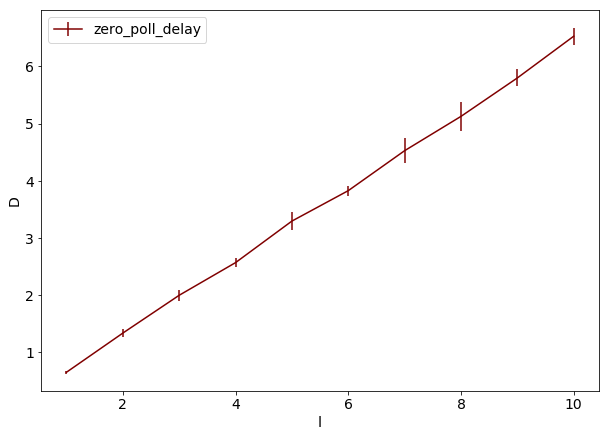

In [55]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(10,7))
plt.errorbar(range(1,11),x0_finalized,std_x0_finalized,color=(0.5,0,0))
plt.xlabel('l')
plt.ylabel('D')
plt.legend(['zero_poll_delay'])
#plt.title('Lower_bound_tightness')
#plt.savefig('lower_bound1.fig')
plt.show()

In [56]:
np.save('DvsL_dict/zero_mean.npy',np.array(x0_finalized))
np.save('DvsL_dict/zero_std.npy',np.array(std_x0_finalized))